# Assignment 6
1. Use yeast dataset from UCI http://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data
2. Remove the first column and use the last column as the target
3. Only leave CYT and VAC classes
4. Replace [0.3, 0.5, 0.7] in feature 2 to null
5. Replace [0.26, 0.36, 0.64] in feature 3 to null
6. Split the data
7. Impute the data (or not, it's your call)
8. Build a outlier detection model to classify VAC from CYT, i.e. 0 from 1
9. Build a classifer using sample augmentation techniques to classify VAC from CYT, i.e. 0 from 1
10. Try different methods and hyper parameters

11. Report perfromance using F-1 score

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import libraries
%matplotlib inline

plt.rcParams["figure.figsize"] = [16, 9]
nan = np.nan

def evaluate_model(classifier):
    print("-"*50)
    print("Train Accuracy :", accuracy_score(y_train, classifier.predict(X_train)))
    print("Train Precision :", precision_score(y_train, classifier.predict(X_train)))    
    print("Train Recall :", recall_score(y_train, classifier.predict(X_train)))
    print("Train F1-Score :", f1_score(y_train, classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, classifier.predict(X_test)))
    print("Test Precision :", precision_score(y_test, classifier.predict(X_test)))    
    print("Test Recall :", recall_score(y_test, classifier.predict(X_test)))
    print("Test F1-Score :", f1_score(y_test, classifier.predict(X_test)))    
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, classifier.predict(X_test)))

In [2]:
# Load dataset
url = "https://people.arcada.fi/~martinel/"
names = ['Sequence Name','mcg', 'gvh', 'alm', 'mit', 'erl','pox','vac','nuc', 'label']
df = pd.read_csv(url + 'yeast.data', header=None, names=names, delim_whitespace=True)
df

,Sequence Name,mcg,gvh,alm,mit,erl,pox,vac,nuc,label
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT
...,...,...,...,...,...,...,...,...,...,...
1479,YUR1_YEAST,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,ME2
1480,ZIP1_YEAST,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1481,ZNRP_YEAST,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,ME2
1482,ZUO1_YEAST,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC


In [3]:
# Only leave CYT and VAC classes
df = (df.loc[(df['label'] == 'CYT') | (df['label'] == 'VAC')])
df.label.unique()

array(['CYT', 'VAC'], dtype=object)

In [4]:
# Replace CYT by 0 and VAC by 1 on target variable
df = df.replace({'label' : { 'CYT':0, 'VAC':1 }})

In [5]:
# Replace [0.3, 0.5, 0.7] in feature 2 to null
df = df.replace({'gvh' : { 0.3:nan, 0.5:nan, 0.7:nan }})

# Replace [0.26, 0.36, 0.64] in feature 3 to null
df = df.replace({'alm' : { 0.26:nan, 0.36:nan, 0.64:nan }})

In [6]:
df.isna().sum()

Sequence Name     0
mcg               0
gvh              26
alm               5
mit               0
erl               0
pox               0
vac               0
nuc               0
label             0
dtype: int64

In [7]:
df

,Sequence Name,mcg,gvh,alm,mit,erl,pox,vac,nuc,label
5,AATC_YEAST,0.51,0.40,0.56,0.17,0.5,0.5,0.49,0.22,0
9,ABP1_YEAST,0.40,0.39,0.60,0.15,0.5,0.0,0.58,0.30,0
12,ACH1_YEAST,0.40,0.42,0.57,0.35,0.5,0.0,0.53,0.25,0
15,ACT_YEAST,0.46,0.44,0.52,0.11,0.5,0.0,0.50,0.22,0
16,ACT2_YEAST,0.47,0.39,0.50,0.11,0.5,0.0,0.49,0.40,0
...,...,...,...,...,...,...,...,...,...,...
1475,YP53_YEAST,0.71,NaN,0.50,0.18,0.5,0.0,0.46,0.22,0
1476,YPT7_YEAST,0.61,0.48,0.54,0.25,0.5,0.0,0.50,0.22,0
1477,R29A_YEAST,0.38,0.32,NaN,0.41,0.5,0.0,0.44,0.11,0
1478,R29B_YEAST,0.38,0.40,0.66,0.35,0.5,0.0,0.43,0.11,0


In [8]:
# Remove the first column and use the last column as the target
X = df.iloc[: ,1:9]
y = df.iloc[:,-1]


In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale data before applying KNNImputer
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Impute the data (or not, it's your call)
imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [10]:
df['label'].value_counts()

0    463
1     30
Name: label, dtype: int64

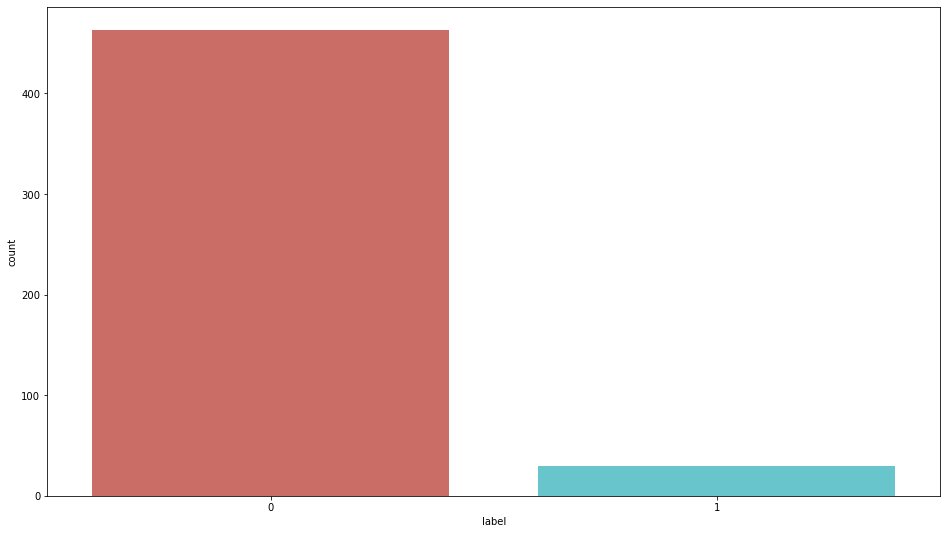

In [11]:
sns.countplot(x='label', data=df, palette='hls')
plt.show()

In [12]:
df.groupby('label').mean()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
label,,,,,,,,
0,0.480713,0.469203,0.534510,0.227106,0.50432,0.00108,0.499395,0.257235
1,0.547667,0.520714,0.472414,0.201000,0.50000,0.00000,0.525000,0.250667


In [13]:
CYT = len(df[df['label']==0])
VAC = len(df[df['label']==1])
PCT_CYT = CYT/(CYT+VAC)
print(f"Percentage of CYT is {PCT_CYT*100:.2f}")
PCT_VAC = VAC/(CYT+VAC)
print(f"Percentage of VAC is {PCT_VAC*100:.2f}")

Percentage of CYT is 93.91
Percentage of VAC is 6.09


Our classes are imbalanced, and the ratio of CYT to VAC is 94:6

In [15]:
# Fit the model
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)
# Evaluate the model
evaluate_model(model)

--------------------------------------------------
Train Accuracy : 0.9543147208121827
Train Precision : 1.0
Train Recall : 0.3333333333333333
Train F1-Score : 0.5
Train Confusion Matrix:
[[367   0]
 [ 18   9]]
--------------------------------------------------
Test Accuracy : 0.9595959595959596
Test Precision : 0.0
Test Recall : 0.0
Test F1-Score : 0.0
Test Confusion Matrix:
[[95  1]
 [ 3  0]]


# Outlier detection

In [20]:
from sklearn.metrics import f1_score
from sklearn.svm import OneClassSVM

# Define outlier detection model
model = OneClassSVM(gamma='scale', nu=0.01)

# Fit on majority class
X_train = X_train[y_train==0]
model.fit(X_train)

# Detect outliers in the test set
y_pred = model.predict(X_test)

# Mark inliers 1, outliers -1
y_test[y_test == 1] = -1
y_test[y_test == 0] = 1

# Calculate score
score = f1_score(y_test, y_pred, pos_label=-1)
print('F1 Score: %.3f' % score)

F1 Score: 0.667


# Undersampling

Random under-sampling:
0    30
1    30
Name: label, dtype: int64


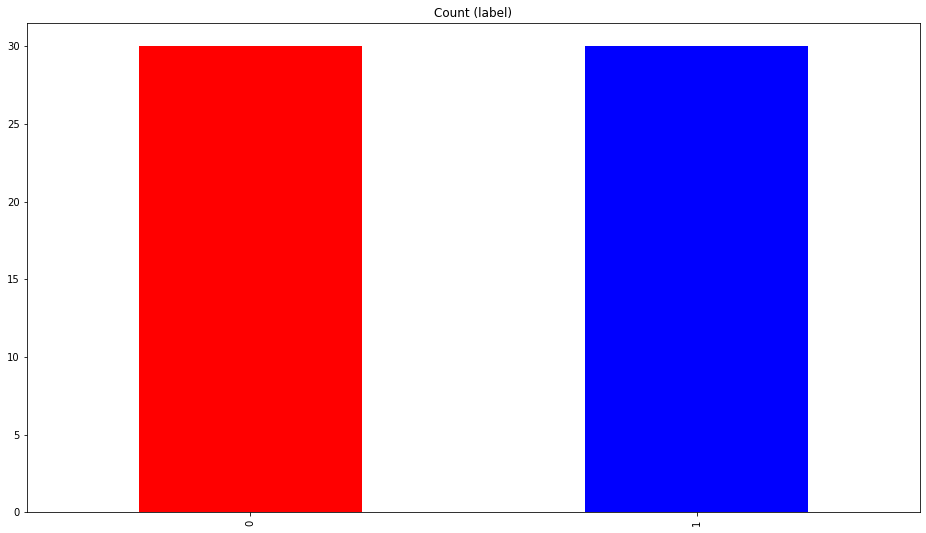

In [17]:
# Class count
count_class_0, count_class_1 = df.label.value_counts()
 
# Divide by class
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
    
print('Random under-sampling:')
print(df_test_under.label.value_counts())
colors = ['r', 'b']
df_test_under.label.value_counts().plot(kind='bar', title='Count (label)',color = colors);

In [19]:
# Remove the first column and use the last column as the target
X = df_test_under.iloc[: ,1:9]
y = df_test_under.iloc[:,-1]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale data before applying KNNImputer
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Impute the data (or not, it's your call)
imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Fit the model
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)
# Evaluate the model
evaluate_model(model)

--------------------------------------------------
Train Accuracy : 0.9166666666666666
Train Precision : 0.92
Train Recall : 0.92
Train F1-Score : 0.92
Train Confusion Matrix:
[[21  2]
 [ 2 23]]
--------------------------------------------------
Test Accuracy : 0.3333333333333333
Test Precision : 0.2
Test Recall : 0.2
Test F1-Score : 0.20000000000000004
Test Confusion Matrix:
[[3 4]
 [4 1]]


# Oversampling

Random over-sampling:
0    463
1    463
Name: label, dtype: int64


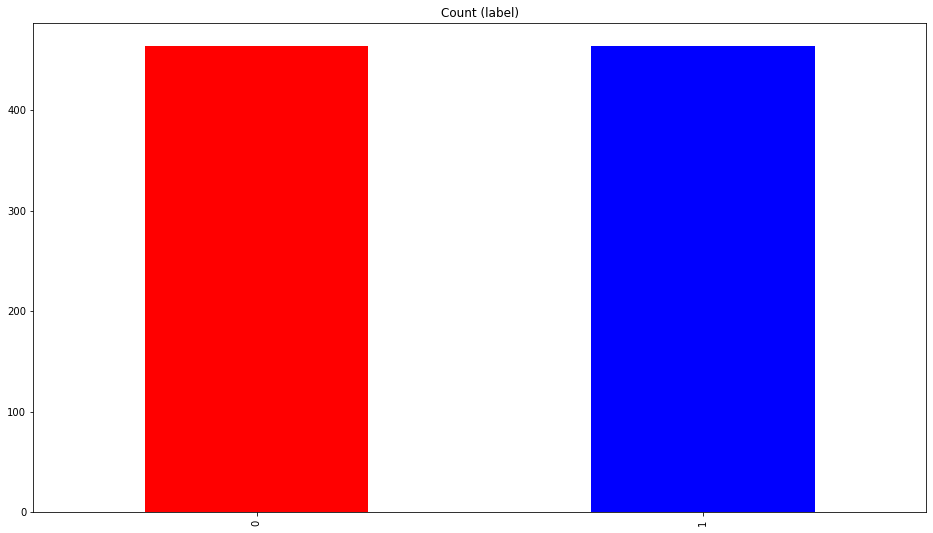

In [21]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.label.value_counts())
colors = ['r', 'b']
df_test_over.label.value_counts().plot(kind='bar', title='Count (label)',color = colors);

In [23]:
# Remove the first column and use the last column as the target
X = df_test_over.iloc[: ,1:9]
y = df_test_over.iloc[:,-1]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale data before applying KNNImputer
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Impute the data (or not, it's your call)
imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Fit the model
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)
# Evaluate the model
evaluate_model(model)

--------------------------------------------------
Train Accuracy : 0.7891891891891892
Train Precision : 0.9372384937238494
Train Recall : 0.6136986301369863
Train F1-Score : 0.7417218543046359
Train Confusion Matrix:
[[360  15]
 [141 224]]
--------------------------------------------------
Test Accuracy : 0.7204301075268817
Test Precision : 0.9259259259259259
Test Recall : 0.5102040816326531
Test F1-Score : 0.6578947368421053
Test Confusion Matrix:
[[84  4]
 [48 50]]


# Sample augmentation techniques **imbalanced-learn**

In [24]:
!pip install -U imbalanced-learn

In [25]:
# Load dataset
url = "https://people.arcada.fi/~martinel/"
names = ['Sequence Name','mcg', 'gvh', 'alm', 'mit', 'erl','pox','vac','nuc', 'label']
df = pd.read_csv(url + 'yeast.data', header=None, names=names, delim_whitespace=True)

# Only leave CYT and VAC classes
df = (df.loc[(df['label'] == 'CYT') | (df['label'] == 'VAC')])
df.label.unique()

# Replace CYT by 0 and VAC by 1 on target variable
df = df.replace({'label' : { 'CYT':0, 'VAC':1 }})

df.columns = np.arange(10) 

# Remove the first column and use the last column as the target
X = df.iloc[: ,1:9]
y = df.iloc[:,-1]

# Metrics
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.tree import DecisionTreeClassifier

def classify(X, y):

    print(f"Samples of class 0: {y.shape[0] - np.sum(y)}")
    print(f"Samples of class 1: {np.sum(y)}")

    # Defines the model to be used
    model = DecisionTreeClassifier(max_depth=3)

    avg_accuracy = []
    avg_precision = []
    avg_recall = []
    avg_f1score = []

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Scale data before applying KNNImputer
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Impute the data (or not, it's your call)
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Train
    model.fit(X_train, y_train)

    evaluate_model(model)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Applies DT without fixing the class imbalance problem.
def dummy_decision_tree():    
    classify(X, y)

# Applies Random Undersampling
def under_sampler():
    rus = RandomUnderSampler()
    X_a, y_a = rus.fit_resample(X, y)

    classify(X_a, y_a)

# Applies Random Oversampling
def over_sampler():
    ros = RandomOverSampler()
    X_b, y_b = ros.fit_resample(X, y)
    
    classify(X_b, y_b)

# Applies Synthetic Data Augmentation through SMOTE
def smote():
    smote= SMOTE()
    X_c, y_c = smote.fit_resample(X, y)
    classify(X_c, y_c)    

In [26]:
dummy_decision_tree()

Samples of class 0: 463
Samples of class 1: 30
--------------------------------------------------
Train Accuracy : 0.6013513513513513
Train Precision : 0.9861111111111112
Train Recall : 0.19452054794520549
Train F1-Score : 0.32494279176201374
Train Confusion Matrix:
[[374   1]
 [294  71]]
--------------------------------------------------
Test Accuracy : 0.6075268817204301
Test Precision : 1.0
Test Recall : 0.25510204081632654
Test F1-Score : 0.40650406504065045
Test Confusion Matrix:
[[88  0]
 [73 25]]


In [27]:
under_sampler()

Samples of class 0: 30
Samples of class 1: 30
--------------------------------------------------
Train Accuracy : 0.7378378378378379
Train Precision : 0.8766519823788547
Train Recall : 0.5452054794520548
Train F1-Score : 0.6722972972972973
Train Confusion Matrix:
[[347  28]
 [166 199]]
--------------------------------------------------
Test Accuracy : 0.6827956989247311
Test Precision : 0.8979591836734694
Test Recall : 0.4489795918367347
Test F1-Score : 0.5986394557823129
Test Confusion Matrix:
[[83  5]
 [54 44]]


In [28]:
over_sampler()

Samples of class 0: 463
Samples of class 1: 463
--------------------------------------------------
Train Accuracy : 0.7486486486486487
Train Precision : 0.770392749244713
Train Recall : 0.6986301369863014
Train F1-Score : 0.7327586206896552
Train Confusion Matrix:
[[299  76]
 [110 255]]
--------------------------------------------------
Test Accuracy : 0.7956989247311828
Test Precision : 0.8571428571428571
Test Recall : 0.7346938775510204
Test F1-Score : 0.7912087912087913
Test Confusion Matrix:
[[76 12]
 [26 72]]


In [29]:
smote()

Samples of class 0: 463
Samples of class 1: 463
--------------------------------------------------
Train Accuracy : 0.6391891891891892
Train Precision : 0.6069868995633187
Train Recall : 0.7616438356164383
Train F1-Score : 0.6755771567436208
Train Confusion Matrix:
[[195 180]
 [ 87 278]]
--------------------------------------------------
Test Accuracy : 0.6236559139784946
Test Precision : 0.6186440677966102
Test Recall : 0.7448979591836735
Test F1-Score : 0.675925925925926
Test Confusion Matrix:
[[43 45]
 [25 73]]


# Hyperparameter tuning

In [30]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "f1")

grid_search.fit(X_train, y_train)                           

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(max_depth=3), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='f1', verbose=1)

In [31]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5)

In [32]:
dt_best = grid_search.best_estimator_
evaluate_model(dt_best)

--------------------------------------------------
Train Accuracy : 0.9743243243243244
Train Precision : 0.9505208333333334
Train Recall : 1.0
Train F1-Score : 0.9746328437917222
Train Confusion Matrix:
[[356  19]
 [  0 365]]
--------------------------------------------------
Test Accuracy : 0.9623655913978495
Test Precision : 0.9333333333333333
Test Recall : 1.0
Test F1-Score : 0.9655172413793104
Test Confusion Matrix:
[[81  7]
 [ 0 98]]
